In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ECOS      # the solver we use in this hw 
# import Hypatia # other solvers you can try
# import COSMO   # other solvers you can try 
using ProgressMeter

# using Pkg
# Pkg.add("ProgressMeter")
include(joinpath(@__DIR__,"utils/rendezvous.jl"))

  Activating environment at `~/Desktop/OCRL_Project/Project.toml`
   Installed CRlibm_jll ─────────── v1.0.1+0
   Installed MakieCore ──────────── v0.6.9
   Installed DataStructures ─────── v0.18.19
   Installed FreeTypeAbstraction ── v0.9.9
   Installed FreeType ───────────── v4.1.1
   Installed StatsBase ──────────── v0.33.21
   Installed DynamicalSystems ───── v2.3.2
   Installed IntervalRootFinding ── v0.5.11
   Installed MarchingCubes ──────── v0.1.9
   Installed FillArrays ─────────── v1.10.0
   Installed ErrorfreeArithmetic ── v0.5.2
   Installed SimpleDiffEq ───────── v1.11.1
   Installed DelayEmbeddings ────── v2.4.1
   Installed ChaosTools ─────────── v2.9.0
   Installed Clustering ─────────── v0.14.4
   Installed LombScargle ────────── v1.0.3
   Installed UnicodePlots ───────── v2.12.4
   Installed Wavelets ───────────── v0.9.5
   Installed GR ─────────────────── v0.73.3
   Installed ADTypes ────────────── v0.2.7
   Installed StatsFuns ──────────── v1.3.1
   Installed Progre

thruster_model (generic function with 1 method)

In [2]:
# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

vec_from_mat (generic function with 1 method)

In [3]:
function create_dynamics(dt::Real)::Tuple{Matrix,Matrix}
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    nx = size(A, 1)
    nu = size(B, 2)

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k

    matrix = [A B; zeros(nu, nx + nu)]
    exp_matrix = exp(matrix *dt)

    Ad = exp_matrix[1:nx, 1:nx]
    Bd = exp_matrix[1:nx, nx+1:nx+nu]


    return Ad, Bd
end

create_dynamics (generic function with 1 method)

In [4]:
@testset "discrete dynamics" begin 
    A,B = create_dynamics(1.0)
    
    x = [1,3,-.3,.2,.4,-.5]
    u = [-.1,.5,.3]
    
    # test these matrices 
    @test isapprox(A*x + B*u, [1.195453, 3.424786, -0.78499972, 0.190925, 0.4495759, -0.4699993], atol = 1e-3)
    @test isapprox(det(A), 1, atol = 1e-8)
    @test isapprox(norm(B,Inf), 0.0999999803, atol = 1e-5)
    
end

Test Summary:     | Pass  Total
discrete dynamics |    3      3


Test.DefaultTestSet("discrete dynamics", Any[], 3, false, false)

## HW solution 

simulating 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers /home/peter/.julia/packages/HTTP/vnQzp/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/peter/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


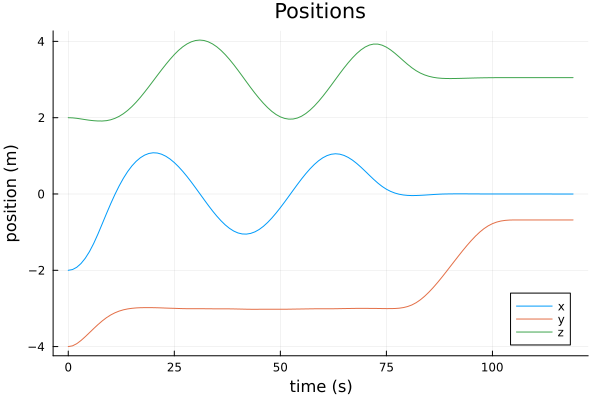

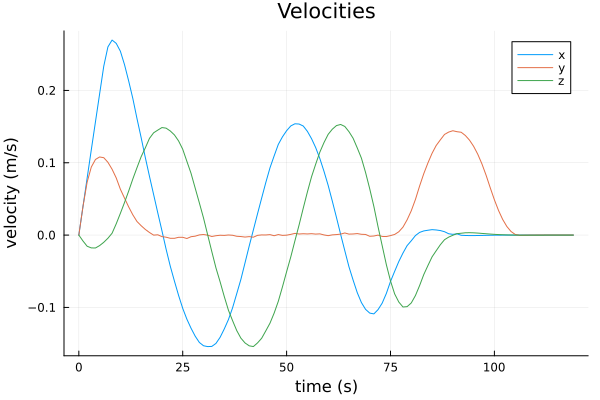

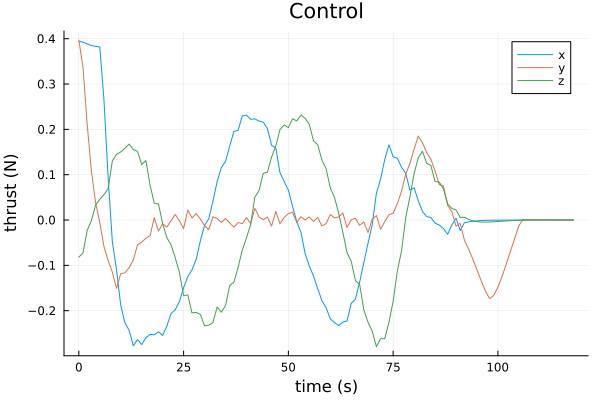

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(RawFD(21) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007fbfedb73dc0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

Test Summary: |
convex mpc    | No tests


Test.DefaultTestSet("convex mpc", Any[], 0, false, false)

In [8]:

"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    xg::Vector, # goal state 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    #check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # TODO: implement cost function
    obj = 0
    for k = 1:N_mpc-1
        obj += 0.5*cvx.quadform(X[:,k] - X_ref_window[k], Q) + 0.5*cvx.quadform(U[:,k], R)
    end

    obj += 0.5*cvx.quadform(X[:,N_mpc] - X_ref_window[N_mpc], Q)
    

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    prob.constraints += (X[:,1] == xic)
    for i = 1:N_mpc-1
        prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i])
        prob.constraints += (U[:,i]<=u_max)
        prob.constraints += (U[:,i]>=u_min) 
        prob.constraints += (X[2,i] <= xg[2])
    end
    prob.constraints += (X[2,N_mpc] <= xg[2])
    prob.constraints += (X[:,N_mpc] == xg)

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end


function extended_kalman_filter(xi, 
                                xg,
                                u, 
                                Ad,
                                Bd)

    # get our sizes for state and control
    nx = length(xi)
    nu = length(u)


    Q_kf = 0.01 * Matrix{Float64}(I, nx, nx)  # Process noise covariance
    R_kf = 0.1 * Matrix{Float64}(I, nx, nx)   # Measurement noise covariance

    function f(x, u)
        return Ad*x + Bd*u
    end

    function h(x)
        return x
    end

    x_pred = f(xi, u)
    F = FD.jacobian(f, xi, u)
    P_pred = F * Q_kf * F' + R_kf

    y = xg - h(x_pred)
    H = FD.jacobian(h, x_pred)
    S = H * P_pred * H' + R_kf
    K = P_pred * H' * inv(S)

    xi = x_pred + K * y
    P = (Matrix{Float64}(I, nx, nx) - K * H) * P_pred
    
    @assert size(xi) == (nx,)

    return xi

end



@testset "convex mpc" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)
    # println(size(A))
    # println(size(B))

    # Ad, Bd = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 100 
    t_vec = 0:dt:((N-1)*dt)
    X_ref = [desired_trajectory(x0,xg,N,dt)...,[xg for i = 1:N]...] 
    
    # MPC window size 
    N_mpc = 20 
    
    # sim size and setup 
    N_sim = N + 20 
    t_vec = 0:dt:((N_sim-1)*dt)
    X_sim = [zeros(nx) for i = 1:N_sim]
    X_sim[1] = x0 
    U_sim = [zeros(nu) for i = 1:N_sim-1]
    
    # simulate 
    @showprogress "simulating" for i = 1:N_sim-1 
        
        # get state estimate

        #1. State Estimation: from homework
        xi_estimate = state_estimate(X_sim[i], xg)

        # xi_test = state_estimate(X_sim[i], xg)
        # size(xi_test)

        # xi_estimate = X_sim[i]

        # # #2. EKF for state estimation
        # xi_estimate = extended_kalman_filter(xi_estimate, xg, U_sim[i], A, B)
  
        
        # TODO: given a window of N_mpc timesteps, get current reference trajectory
        X_ref_tilde = X_ref[i:i+N_mpc-1]
        
        # TODO: call convex mpc controller with state estimate 
        u_mpc = convex_mpc(A,B,X_ref_tilde,xi_estimate,xg,u_min,u_max,N_mpc)
        
        # commanded control goes into thruster model where it gets modified 
        U_sim[i] = thruster_model(X_sim[i], xg, u_mpc)
        
        # simulate one step 
        X_sim[i+1] = A*X_sim[i] + B*U_sim[i]
    end


    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
                    xlabel = "time (s)", ylabel = "position (m)",
                    label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                    label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control",
            xlabel = "time (s)", ylabel = "thrust (N)",
                    label = ["x" "y" "z"]))

    
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------



end

## Without noise 

simulating 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Listening on: 127.0.0.1:8709, thread id: 1
└ @ HTTP.Servers /home/peter/.julia/packages/HTTP/vnQzp/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8709
└ @ MeshCat /home/peter/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


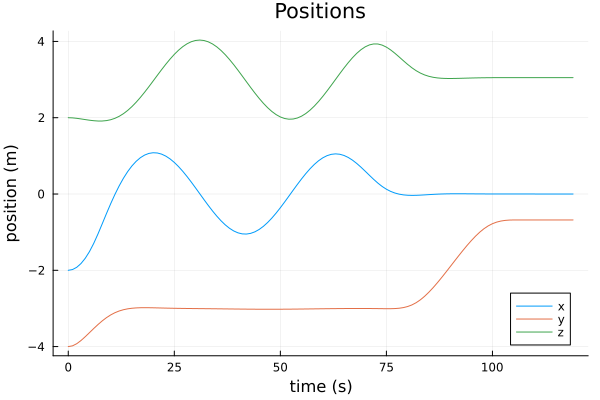

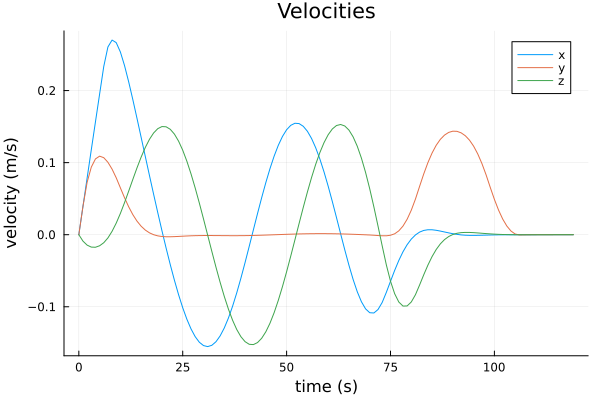

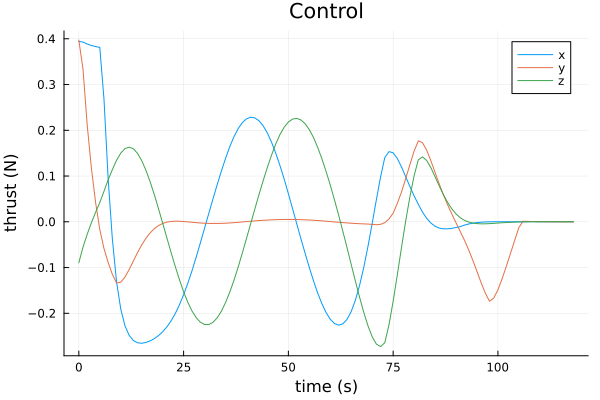

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8709, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8709), "127.0.0.1", "8709", nothing, Sockets.TCPServer(RawFD(83) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007fbfec597730, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

Test Summary: |
convex mpc    | No tests


Test.DefaultTestSet("convex mpc", Any[], 0, false, false)

In [46]:

"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    xg::Vector, # goal state 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    #check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # TODO: implement cost function
    obj = 0
    for k = 1:N_mpc-1
        obj += 0.5*cvx.quadform(X[:,k] - X_ref_window[k], Q) + 0.5*cvx.quadform(U[:,k], R)
    end

    obj += 0.5*cvx.quadform(X[:,N_mpc] - X_ref_window[N_mpc], Q)
    

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    prob.constraints += (X[:,1] == xic)
    for i = 1:N_mpc-1
        prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i])
        prob.constraints += (U[:,i]<=u_max)
        prob.constraints += (U[:,i]>=u_min) 
        prob.constraints += (X[2,i] <= xg[2])
    end
    prob.constraints += (X[2,N_mpc] <= xg[2])
    prob.constraints += (X[:,N_mpc] == xg)

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end


function extended_kalman_filter(xi, 
                                xg,
                                u, 
                                Ad,
                                Bd)

    # get our sizes for state and control
    nx = length(xi)
    nu = length(u)


    Q_kf = 0.01 * Matrix{Float64}(I, nx, nx)  # Process noise covariance
    R_kf = 0.1 * Matrix{Float64}(I, nx, nx)   # Measurement noise covariance

    function f(x, u)
        return Ad*x + Bd*u
    end

    function h(x)
        return x
    end

    x_pred = f(xi, u)
    F = FD.jacobian(f, xi, u)
    P_pred = F * Q_kf * F' + R_kf

    y = xg - h(x_pred)
    H = FD.jacobian(h, x_pred)
    S = H * P_pred * H' + R_kf
    K = P_pred * H' * inv(S)

    xi = x_pred + K * y
    P = (Matrix{Float64}(I, nx, nx) - K * H) * P_pred
    
    @assert size(xi) == (nx,)

    return xi

end



function state_estimate_noise(xi, xg)
    if norm(xi - xg) < 0.1
        return xi  # If close to goal, return current estimate unchanged
    else
        # Simulate bias and Gaussian noise

        noise_std, bias_std = 0.1, 0.01
        bias = bias_std * randn(length(xi))  # Bias noise vector matching length of xi
        noise = noise_std * randn(length(xi))  # Gaussian noise vector matching length of xi
        
        # Add noise and bias to the estimated state
        noisy_estimate = xi + noise + bias
        
        return noisy_estimate
    
    end
end



@testset "convex mpc" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)
    # println(size(A))
    # println(size(B))

    # Ad, Bd = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 100 
    t_vec = 0:dt:((N-1)*dt)
    X_ref = [desired_trajectory(x0,xg,N,dt)...,[xg for i = 1:N]...] 
    
    # MPC window size 
    N_mpc = 20 
    
    # sim size and setup 
    N_sim = N + 20 
    t_vec = 0:dt:((N_sim-1)*dt)
    X_sim = [zeros(nx) for i = 1:N_sim]
    X_sim[1] = x0 
    U_sim = [zeros(nu) for i = 1:N_sim-1]

    
    
    # simulate 
    @showprogress "simulating" for i = 1:N_sim-1 
        
        # get state estimate

        #1. State Estimation: from homework
        #xi_estimate = state_estimate_noise(X_sim[i], xg)

        # xi_test = state_estimate(X_sim[i], xg)
        # size(xi_test)

        # xi_estimate = X_sim[i]

        # # #2. EKF for state estimation
        # xi_estimate = extended_kalman_filter(xi_estimate, xg, U_sim[i], A, B)
  
        
        # TODO: given a window of N_mpc timesteps, get current reference trajectory
        X_ref_tilde = X_ref[i:i+N_mpc-1]
        
        # TODO: call convex mpc controller with state estimate 
        u_mpc = convex_mpc(A,B,X_ref_tilde,X_sim[i],xg,u_min,u_max,N_mpc)
        
        # commanded control goes into thruster model where it gets modified 
        U_sim[i] = thruster_model(X_sim[i], xg, u_mpc)
        
        # simulate one step 
        X_sim[i+1] = A*X_sim[i] + B*U_sim[i]
    end


    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
                    xlabel = "time (s)", ylabel = "position (m)",
                    label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                    label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control",
            xlabel = "time (s)", ylabel = "thrust (N)",
                    label = ["x" "y" "z"]))

    
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------



end

## Add noise and time delay

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/packages/Convex/b2S4H/src/solution.jl:342
simulating   2%|▊                                        |  ETA: 0:00:09┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/peter/.julia/pack

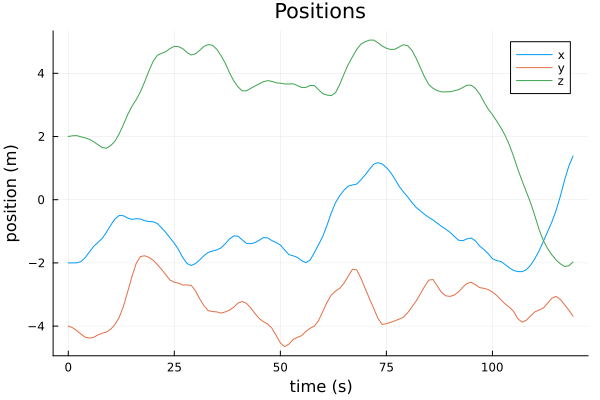

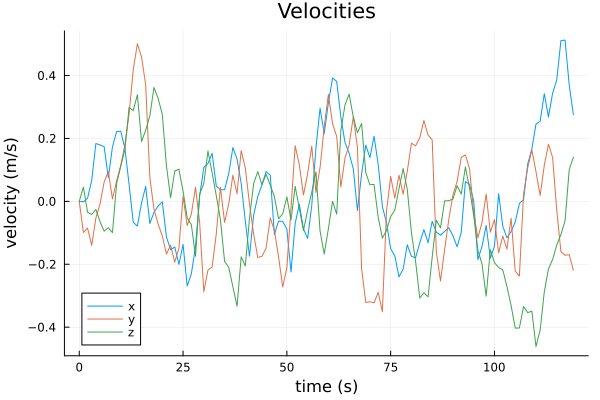

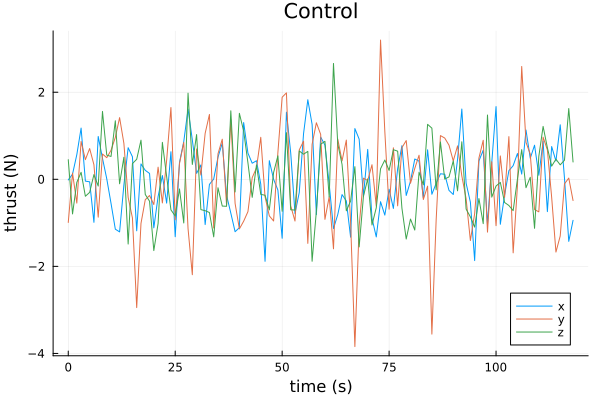

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8712, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8712), "127.0.0.1", "8712", nothing, Sockets.TCPServer(RawFD(101) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007fbfec348be0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

Test Summary: |
convex mpc    | No tests


Test.DefaultTestSet("convex mpc", Any[], 0, false, false)

In [49]:

"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    xg::Vector, # goal state 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    #check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # TODO: implement cost function
    obj = 0
    for k = 1:N_mpc-1
        obj += 0.5*cvx.quadform(X[:,k] - X_ref_window[k], Q) + 0.5*cvx.quadform(U[:,k], R)
    end

    obj += 0.5*cvx.quadform(X[:,N_mpc] - X_ref_window[N_mpc], Q)
    

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    prob.constraints += (X[:,1] == xic)
    for i = 1:N_mpc-1
        prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i])
        prob.constraints += (U[:,i]<=u_max)
        prob.constraints += (U[:,i]>=u_min) 
        prob.constraints += (X[2,i] <= xg[2])
    end
    prob.constraints += (X[2,N_mpc] <= xg[2])
    prob.constraints += (X[:,N_mpc] == xg)

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end



function state_estimate_noise(xi, xg, noise_std, bias_std, X_his)
    if norm(xi - xg) < 1
        return xi  # Return current estimate unchanged if close to goal
    else
        # Simulate bias and Gaussian noise
        bias = bias_std * randn(length(xi))  # Bias noise vector matching length of xi
        noise = noise_std * randn(length(xi))  # Gaussian noise vector matching length of xi
        
        # Add noise and bias to the estimated state
        noisy_estimate = xi + noise + bias

        return noisy_estimate

    end
end


@testset "convex mpc" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 100 
    t_vec = 0:dt:((N-1)*dt)
    X_ref = [desired_trajectory(x0,xg,N,dt)...,[xg for i = 1:N]...] 
    
    # MPC window size 
    N_mpc = 20 
    
    # sim size and setup 
    N_sim = N + 20 
    t_vec = 0:dt:((N_sim-1)*dt)
    X_sim = [zeros(nx) for i = 1:N_sim]
    X_sim[1] = x0 
    U_sim = [zeros(nu) for i = 1:N_sim-1]

    X_his = [zeros(nx) for i = 1:N_sim]


# Simulation loop
@showprogress "simulating" for i = 1:N_sim-1

    
    xi_estimate = state_estimate_noise(X_sim[i], xg, 0.5, 0.1)  # Example noise_std = 0.5, bias_std = 0.1, delay = 1

    X_his[i+1] = xi_estimate

    delay = true

    if delay
        xi_estimate = X_his[i]
    end
    

    # TODO: given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    
    u_mpc = convex_mpc(A, B, X_ref_tilde, xi_estimate, xg, u_min, u_max, N_mpc)
    
    U_sim[i] = thruster_model(X_sim[i], xg, u_mpc)
    
    # Simulate one step 
    X_sim[i+1] = A * X_sim[i] + B * U_sim[i]
end


    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
                    xlabel = "time (s)", ylabel = "position (m)",
                    label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                    label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control",
            xlabel = "time (s)", ylabel = "thrust (N)",
                    label = ["x" "y" "z"]))

    
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------



end